In [1]:
import pandas as pd

from plotnine import *

import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as rvectors
from rpy2.robjects import pandas2ri

import scipy as sp
from scipy.stats import stats

import statsmodels as sm
from statsmodels.sandbox import stats
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline
r = ro.r

Activate the pandas conversion for rpy2. See, https://pandas.pydata.org/pandas-docs/stable/r_interface.html

In [2]:
pandas2ri.activate()

Import the R packages that will be used in this analysis.

In [3]:
packageNames = ('afex', 'lsmeans', 'ez')
 
if all(rpackages.isinstalled(x) for x in packageNames):
 
    have_packages = True
 
else:
 
   have_packages = False
 
if not have_packages:
 
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
 
    packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]
 
    if len(packnames_to_install) > 0:
 
        utils.install_packages(rvectors.StrVector(packnames_to_install))

In [4]:
df = pd.read_csv("websearch2.csv")

In [5]:
df.tail(5)

,Subject,Engine,Order,Searches,Effort
55,28,Bing,1,192,4
56,29,Google,1,162,5
57,29,Bing,2,163,3
58,30,Google,2,146,5
59,30,Bing,1,137,2


In [6]:
df.groupby(['Engine']).describe()

Effort                                              Order       ...   \
        count      mean       std  min  25%  50%  75%  max count mean  ...    
Engine                                                                 ...    
Bing     30.0  4.066667  1.760355  1.0  2.0  4.0  6.0  7.0  30.0  1.5  ...    
Google   30.0  3.733333  1.740657  1.0  2.0  4.0  5.0  7.0  30.0  1.5  ...    

       Searches        Subject                                                
            75%    max   count  mean       std  min   25%   50%    75%   max  
Engine                                                                        
Bing     184.75  241.0    30.0  15.5  8.803408  1.0  8.25  15.5  22.75  30.0  
Google   161.75  198.0    30.0  15.5  8.803408  1.0  8.25  15.5  22.75  30.0  

[2 rows x 32 columns]

Determine how many subjects took part in this experiment?

In [7]:
df.Subject.nunique()

30

Determine the average number of searches required for the search engine that had the greatest average overall?

In [8]:
df.groupby(['Engine']).Searches.mean().idxmax()

'Bing'

Display histograms of Searches by search engine.

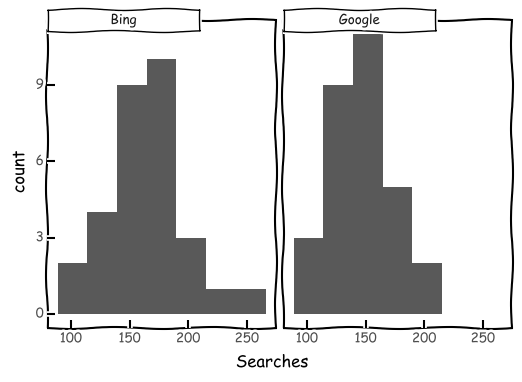

<ggplot: (279246281)>

In [9]:
(
    ggplot(df) +
    aes(x='Searches') +
    geom_histogram(binwidth=2) +
    stat_bin(bins=7) +
    facet_wrap('~Engine') + 
    theme_xkcd()
)

Display box plots of searches by search engine.

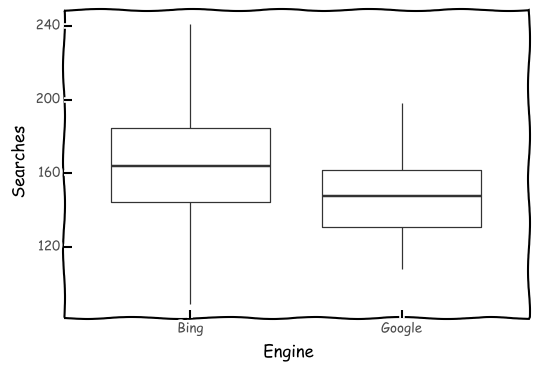

<ggplot: (281029113)>

In [10]:
(
    ggplot(df, aes(x='Engine', y='Searches')) +
    geom_boxplot() +
    theme_xkcd()
)

Test for normality using Shapiro-Wilk.

https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.shapiro.html

In [11]:
df.sort_values('Subject').groupby(['Engine']).Searches.apply(lambda x : sp.stats.shapiro(x))

Engine
Bing      (0.983305990696, 0.904959201813)
Google    (0.970467865467, 0.552055418491)
Name: Searches, dtype: object

Test for homoscedasticity using Levene test for equal variances by Engine. See, https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html

In [12]:
groups = df.sort_values('Subject').groupby(['Engine'])
sp.stats.levene(*[groups.get_group(x).Searches for x in groups.groups], center='median')

LeveneResult(statistic=1.1082233526291065, pvalue=0.29683458221224279)

Conduct and order effect test on Searches using a paired-samples t-test assuming equal variances. See, https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.ttest_rel.html

In [13]:
sp.stats.ttest_rel(*[groups.get_group(x).Searches for x in groups.groups])

Ttest_relResult(statistic=2.5020772424994786, pvalue=0.018237582098993173)

Conduct a nonparametric Wilcoxon signed-rank test on the Effort Likert-type ratings. See, https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.wilcoxon.html

In [14]:
(T, p) = sp.stats.wilcoxon(*[groups.get_group(x).Effort for x in groups.groups])
print('p-value: %s' % p)

p-value: 0.522120930621


Read websearch3.csv.

In [15]:
df = pd.read_csv("websearch3.csv")
df.Searches = df.Searches.astype(int)
df.Engine = df.Engine.astype('category')
df.Effort = df.Effort.astype('category')

In [16]:
df.tail(5)

,Subject,Engine,Order,Searches,Effort
85,29,Bing,1,195,4
86,29,Yahoo,2,182,5
87,30,Google,3,152,1
88,30,Bing,2,188,7
89,30,Yahoo,1,131,3


In [17]:
df.groupby(['Engine']).describe()

Order                                         Searches              \
       count mean       std  min  25%  50%  75%  max    count        mean   
Engine                                                                      
Bing    30.0  2.0  0.830455  1.0  1.0  2.0  3.0  3.0     30.0  159.833333   
Google  30.0  2.0  0.830455  1.0  1.0  2.0  3.0  3.0     30.0  152.666667   
Yahoo   30.0  2.0  0.830455  1.0  1.0  2.0  3.0  3.0     30.0  172.400000   

        ...                 Subject                                          \
        ...      75%    max   count  mean       std  min   25%   50%    75%   
Engine  ...                                                                   
Bing    ...   180.75  214.0    30.0  15.5  8.803408  1.0  8.25  15.5  22.75   
Google  ...   168.50  200.0    30.0  15.5  8.803408  1.0  8.25  15.5  22.75   
Yahoo   ...   190.75  236.0    30.0  15.5  8.803408  1.0  8.25  15.5  22.75   

              
         max  
Engine        
Bing    30.0  
Google  30.0  
Yahoo   30.0  

[3 rows x 24 columns]

Determine many subjects took part in this new experiment?

In [18]:
df.Subject.nunique()

30

Determine the average number of searches required for the search engine that had the greatest average overall?

In [19]:
df.groupby(['Engine']).Searches.mean().idxmax()

'Yahoo'

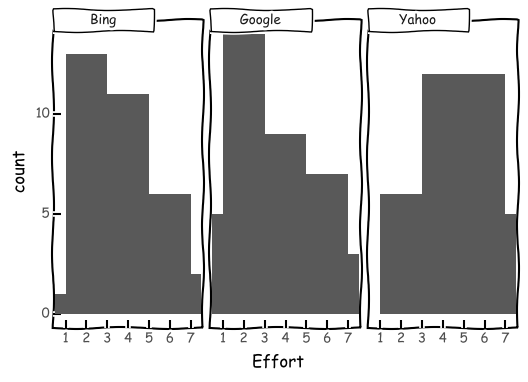

<ggplot: (281123217)>

In [20]:
(
    ggplot(df) +
    aes(x='Effort') +
    geom_histogram(binwidth=2) +
    stat_bin(bins=7) +
    facet_wrap('~Engine') + 
    theme_xkcd()
)

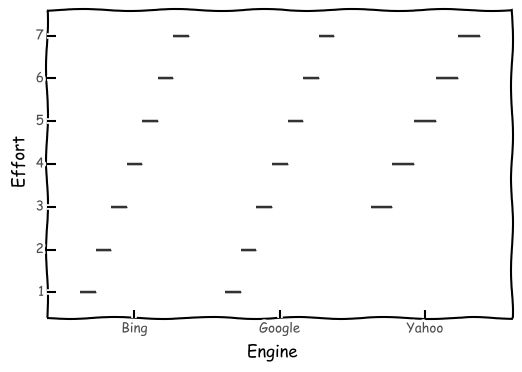

<ggplot: (281282805)>

In [21]:
(
    ggplot(df, aes(x='Engine', y='Effort')) +
    geom_boxplot() +
    theme_xkcd()
)

Conduct a repreated measures ANOVA to determine if there was an order effect on Searches.

Import the R afex package.

In [22]:
afex = rpackages.importr('afex') 

In [23]:
model = afex.aov_ez(id='Subject', dv='Searches', data=df, within=['Order'])
print(r.summary(model))


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                 SS num Df Error SS den Df         F Pr(>F)    
(Intercept) 2351280      1    25351     29 2689.7318 <2e-16 ***
Order          2567      2    64207     58    1.1594 0.3208    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

      Test statistic p-value
Order        0.94165 0.43096


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

       GG eps Pr(>F[GG])
Order 0.94486      0.319

        HF eps Pr(>F[HF])
Order 1.008692   0.320849



In [24]:
model = afex.aov_ez(id='Subject', dv='Searches', data=df, within=['Engine'])
afex.summary_afex_aov(model)
print(r.summary(model))


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                 SS num Df Error SS den Df         F Pr(>F)    
(Intercept) 2351280      1    25351     29 2689.7318 <2e-16 ***
Engine         5987      2    60787     58    2.8562 0.0656 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

       Test statistic p-value
Engine        0.94203 0.43343


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

        GG eps Pr(>F[GG])  
Engine 0.94521    0.06895 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         HF eps Pr(>F[HF])
Engine 1.009098 0.06560302



In [25]:
lsm  = rpackages.importr('lsmeans')
pairwise = lsm.lsmeans(model, "Engine", contr="pairwise", adjust="holm")
print(r.summary(pairwise))

$lsmeans
 Engine   lsmean       SE    df lower.CL upper.CL
 Bing   159.8333 5.744831 86.41 148.4138 171.2529
 Google 152.6667 5.744831 86.41 141.2471 164.0862
 Yahoo  172.4000 5.744831 86.41 160.9804 183.8196

Confidence level used: 0.95 

$contrasts
 contrast         estimate       SE df t.ratio p.value
 Bing - Google    7.166667 8.358844 58   0.857  0.3948
 Bing - Yahoo   -12.566667 8.358844 58  -1.503  0.2763
 Google - Yahoo -19.733333 8.358844 58  -2.361  0.0649

P value adjustment: holm method for 3 tests 




Whatever your previous answer, proceed to do post hoc pairwise comparisons. Conduct manual pairwise comparisons of Searches among levels of Engine using paired-samples t-tests, assuming equal variances and using Holm's sequential Bonferroni procedure to correct for multiple comparisons. 

In [26]:
groups = df.sort_values('Subject').groupby(['Engine'])

pvals = [None]*3
pvals[0] = sp.stats.ttest_ind(groups.get_group('Bing').Searches,
                              groups.get_group('Google').Searches)[1]
pvals[1] = sp.stats.ttest_ind(groups.get_group('Bing').Searches,
                              groups.get_group('Yahoo').Searches)[1]
pvals[2] = sp.stats.ttest_ind(groups.get_group('Google').Searches,
                              groups.get_group('Yahoo').Searches)[1]

(reject, pvals_corrected, _, _) = sm.sandbox.stats.multicomp.multipletests(pvals, method='holm')
min(pvals)

0.019800610129101781

Conduct a nonparametric Friedman test on the Effort Likert-type ratings. Calculate an asymptotic p-value. To the nearest ten-thousandth (four digits), what is the Chi-Square statistic from such a

In [27]:
groups = df.sort_values('Subject').groupby(['Engine'])

measurements = [groups.get_group(x).Effort for x in groups.groups]
sp.stats.friedmanchisquare(*measurements)

FriedmanchisquareResult(statistic=8.0181818181818425, pvalue=0.018149887636971278)

Whatever your previous answer, proceed to do post hoc pairwise comparisons. Conduct manual pairwise comparisons of Effort among levels of Engine with Wilcoxon signed-rank tests, using Holm's sequential Bonferroni procedure to correct for multiple comparisons. 

In [28]:
pvals = [None]*3
pvals[0] = sp.stats.wilcoxon(groups.get_group('Bing').Effort,
                             groups.get_group('Google').Effort)[1]
pvals[1] = sp.stats.wilcoxon(groups.get_group('Bing').Effort,
                             groups.get_group('Yahoo').Effort)[1]
pvals[2] = sp.stats.wilcoxon(groups.get_group('Google').Effort,
                             groups.get_group('Yahoo').Effort)[1]

(reject, pvals_corrected, _, _) = sm.sandbox.stats.multicomp.multipletests(pvals, method='holm')
min(pvals)

0.0099060292976086688

# References

1. http://benalexkeen.com/comparative-statistics-in-python-using-scipy/
2. https://www.marsja.se/repeated-measures-anova-using-python/
3. https://www.youtube.com/watch?v=IXavu8skv9I
4. http://pythonplot.com/